# Advanced pangaeapy usage: Principal Component Analysis

This example tries to reproduce a PCA performed on geochemical XRF measurements published by Burdanowitz et al (2019: https://doi.org/10.1016/j.dsr2.2019.03.003).

We will try to reproduce the plot of the loadings of the first two principal components illustrated in Burdanowitz' Fig. 3:

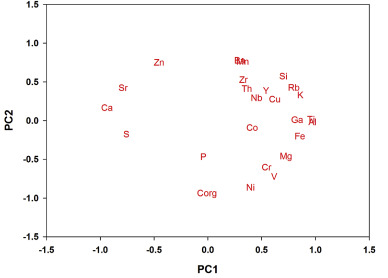

As ususal we have to include the necessary modules first. For this example we use the PCA module from sklearn.

Since the data is distributed over four PANGAEA datasets we need to merge, we also need to define here a helper function which deletes duplicate columns added after merging of data frames.

In [1]:
from pangaeapy import PanDataSet
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler

#a helper function to delete duplicate columns which are added by the pd.merge actions
def drop_y(df):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)

### Data loading and merging
Now we load the datasets from PANGAEA and merge them within one single dataframe .

In [2]:

ds1 = PanDataSet(900972)
ds2 = PanDataSet(900971)
ds3 = PanDataSet(900967)
ds4 = PanDataSet(900968)

#just for convenience, since data is organised in two ways we merge it in two steps
dsC=pd.merge(ds2.data,ds3.data,left_on='Depth',right_on='Depth',suffixes=('', '_y'))
drop_y(dsC)
dsN=pd.merge(ds1.data,ds4.data,left_on='Depth',right_on='Depth',suffixes=('', '_y'))
drop_y(dsN)
#now we concat the frames and drop the index
dsdata=pd.concat([dsN,dsC])
dsdata = dsdata.reset_index(drop=True)

In [3]:
dsdata.columns

Index(['Depth', 'Age', 'SiO2', 'TiO2', 'Al2O3', 'Fe2O3', 'MnO', 'MgO', 'CaO',
       'Na2O', 'K2O', 'P2O5', 'SO3', 'Cl', 'LOI', 'Sum', 'Ba', 'Co', 'Cr',
       'Cu', 'Ga', 'Nb', 'Ni', 'Rb', 'Sr', 'Th', 'V', 'Y', 'Zn', 'Zr',
       'Latitude', 'Longitude', 'Elevation', 'Event', 'Date/Time', 'TOC', 'TN',
       'CaCO3', 'δ15N', 'δ15N std dev', 'δ13C carb', 'δ13C std dev',
       'δ18O carb', 'δ18O std dev'],
      dtype='object')

### Data cleaning
Unfortunately, the dataset has data expressed in % as well as in mg/kg, we therefore need to clean the data first in order to have the same units here. We recalculate % to mg/kg with a factor of 10000.

Further, some values are given as oxides (e.g. SiO2) and some as elements, so we need to convert the oxide weights to elements weights using the oxide factor dict

In [4]:
# 1) the dataset has data expressed in % as well as in mg/kg, we therefore need to clean the data first
#    in order to have the same units here. We recalculate % to mg/kg with a factor of 10000
# 2) oxides need to be converted to elementt weights
oxide={'SiO2':2.1392, 'TiO2':1.6681, 'Al2O3':1.8895, 'Fe2O3':1.4297, 'MnO':1.2912, 'MgO':1.6582, 'CaO':1.3992,
       'Na2O':1.3480, 'K2O':1.2046, 'P2O5':2.2916, 'SO3':2.4972}
for pshort,param in ds1.params.items():
    if pshort in oxide:
        dsdata[pshort]=dsdata[pshort].divide(oxide[pshort])
    if param.unit=='mg/kg':
        dsdata[pshort]=dsdata[pshort].divide(10000)


Lets take a look at the resulting data matrix

In [5]:
dsdata.tail()

,Depth,Age,SiO2,TiO2,Al2O3,Fe2O3,MnO,MgO,CaO,Na2O,...,Date/Time,TOC,TN,CaCO3,δ15N,δ15N std dev,δ13C carb,δ13C std dev,δ18O carb,δ18O std dev
48,2.375,2.867,19.848542,0.392063,6.917174,3.839966,0.043371,2.074539,8.004574,1.446588,...,1993-09-11,1.89,0.23,19.1,8.09,0.06,-0.71,0.03,-3.11,0.04
49,4.390,6.666,21.741773,0.419639,7.144747,3.937889,0.051115,2.104692,7.404231,1.283383,...,1993-09-11,1.01,0.15,19.4,6.84,0.03,-1.91,0.03,-4.69,0.04
50,6.855,10.703,22.190539,0.435226,7.912146,4.364552,0.055762,2.309733,6.009863,1.275964,...,1993-09-11,0.42,0.08,15.6,6.66,0.00,-2.11,0.03,-5.05,0.04
51,6.865,10.707,22.405572,0.444218,7.970363,4.350563,0.056537,2.315764,5.889794,1.261128,...,1993-09-11,0.41,0.09,15.0,6.84,0.04,-2.02,0.03,-4.95,0.04
52,6.875,10.716,22.143792,0.431029,7.790421,4.546408,0.056537,2.261488,6.129217,1.313056,...,1993-09-11,0.45,0.09,15.9,6.98,0.00,-1.75,0.03,-4.74,0.04


### PCA
OK, lets try to perform a PCA on the data. of course we only use the chemical columns, therefore we have slice the dataframe by columns. For this purpose we define a list called elementcols, which contains the columns we need.

In [6]:
elementcols=['SiO2', 'TiO2', 'Al2O3', 'Fe2O3', 'MnO', 'MgO', 'CaO',
             'Na2O', 'K2O', 'P2O5', 'SO3','Ba', 'Co', 'Cr', 'Cu', 
             'Ga', 'Nb', 'Ni', 'Rb', 'Sr', 'Th', 'V', 'Y', 'Zn', 'Zr','TOC','Cl']

X=dsdata[elementcols].values
y = dsdata['Age'].values

But before we continue we have to standardise the data instead using the absolute values. For this purpose we use the  StandardScaler and run its fit method on X.
The result is stored in X_std

In [7]:
scaledX=StandardScaler().fit(X)
X_std = scaledX.transform(X)

Now we can start the analysis. To perform the PCA, we need to defind the number of components (n_components=2), as well as the data we use for the fit (X).

The individual eigenvectors (loadings) of the principal components are stored in the 'sklearn_pca.components_' variable which is a two dim array. 

We put this array into a dataframe (pcaload) for convenience and later plotting. Before we have to transpose the array.. 

Further we need to clean the column names to strip the oxide endings (SiO2 -> Si)

In [8]:
sklearn_pca = sklearnPCA(n_components=2)
pcaresult = sklearn_pca.fit(X_std).transform(X_std)

pcaload=pd.DataFrame(sklearn_pca.components_).transpose()
pcaload=pcaload.rename(columns={0:'PC1',1:'PC2'})
pcaload['Element']=elementcols
pcaload['Element']=pcaload['Element'].str.extract(r'([A-Z][a-z]?)')
pcaload.head()

,PC1,PC2,Element
0,-0.225655,0.193717,Si
1,-0.281415,-0.023892,Ti
2,-0.280033,-0.067507,Al
3,-0.224403,-0.148835,Fe
4,-0.200002,0.269155,Mn


Now lets try to plot this to reproduce the figure of the original publication.

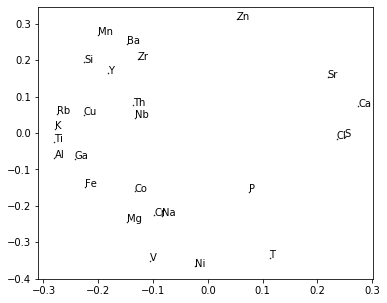

In [10]:
fig = plt.figure(figsize = (6,5))
plt.plot(pcaload['PC1'],pcaload['PC2'], '.',color='k', label=pcaload['Element'],markersize=1)
for i, p in pcaload.iterrows():
        plt.text(p['PC1'], p['PC2'], str(p['Element']),fontsize=10)

### Fail and retry
Unfortunately this approach completely failed to reproduce the figure.

It seems as if some expert knowledge is needed to fully reproduce the results. At this point we need to take a closer look at the methodology the authors of the publication used. A vague hint is given in chapter 2.1 where they state:

_'..Samples for the measurement of total organic carbon (TOC) were treated with 1 M hydrochloric acid (HCl) prior to instrumental analysis'_

So maybe the Cl values have not been included in the analysis to avoid bias caused by sample treatment. So let's see what happens when we exclude Cl values from our analysis :

In [11]:
elementcols.remove('Cl')

and we perform the analyis again:

In [12]:
X=dsdata[elementcols].values
y = dsdata['Age'].values

In [14]:
scaledX=StandardScaler().fit(X)
X_std = scaledX.transform(X)
sklearn_pca = sklearnPCA(n_components=2)
pcares = sklearn_pca.fit(X_std).transform(X_std)
#we can add the loadings to the original
pcaresf=pd.DataFrame(pcares)
dsdata['PCA1']=pcaresf[0]
dsdata['PCA2']=pcaresf[1]
pcaload=pd.DataFrame(sklearn_pca.components_).transpose()
pcaload=pcaload.rename(columns={0:'PC1',1:'PC2'})
pcaload['Element']=elementcols
pcaload['Element']=pcaload['Element'].str.extract(r'([A-Z][a-z]?)')
pcaload.head()

,PC1,PC2,Element
0,0.231235,0.195818,Si
1,0.289454,-0.021371,Ti
2,0.287417,-0.065147,Al
3,0.230098,-0.147079,Fe
4,0.204052,0.270933,Mn


### Success
And voila we can more or less reproduce the figure given in Burdanowitz paper. 

I know: the eigenvalues look different, maybe this is caused by our standadisation approach. 
    
But for now I am quite happy with the result. ;) 

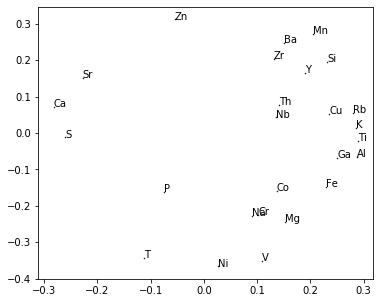

In [16]:
fig = plt.figure(figsize = (6,5))
plt.plot(pcaload['PC1'],pcaload['PC2'], '.',color='k', label=pcaload['Element'],markersize=1)
for i, p in pcaload.iterrows():
        plt.text(p['PC1'], p['PC2'], str(p['Element']),fontsize=10)

As an extra we can try to plot the eigenvalues according to their ages. And it seems as if there are some distinct age related clusters..

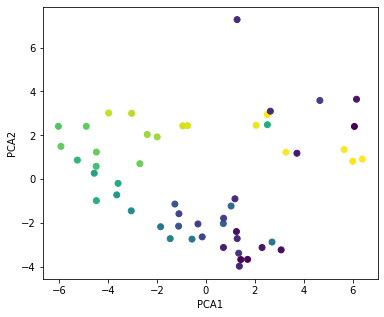

In [18]:
fig = plt.figure(figsize = (6,5))
plt.scatter(dsdata['PCA1'],dsdata['PCA2'], c=dsdata['Age'])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()